In [14]:
import typing as tp
import numpy as np

In [15]:
class CustomAdaBoost:
    def __init__(
            self,
            n_estimators: int = 50,
            max_depth: int = 1,
            min_samples_split: int = 2,
            min_samples_leaf: int = 1
    ):
        self.n_estimators: int = n_estimators
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split
        self.min_samples_leaf: int = min_samples_leaf
        self.alpha_lst: list[float] = []
        self.trees: list[DecisionTreeClassifier] = []

    def fit(self, X, y) -> None:
        n_samples, n_features = X.shape
        weights = np.ones(n_samples) / n_samples
        for _ in range(self.n_estimators):
            dt = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
            )
            dt.fit(X, y, weights)
            y_pred = dt.predict(X)
            miss = self._calc_miss(weights, y, y_pred)
            alpha_t = self._calc_optimal_alpha(miss)
            margin = y * y_pred
            weights = self._update_weights(alpha_t, margin, weights)
            weights = self._normalize_weights(weights)
            self.alpha_lst.append(alpha_t)
            self.trees.append(dt)

    @staticmethod
    def _normalize_weights(weights: np.ndarray[float]) -> np.ndarray[float]:
        return weights / np.sum(weights)

    @staticmethod
    def _update_weights(alpha_t, margin: np.ndarray[int], weights: np.ndarray[float]) -> np.ndarray[float]:
        return weights * np.exp(-alpha_t * margin)

    @staticmethod
    def _calc_optimal_alpha(miss: float) -> float:
        # maybe eps
        eps = 1e-8
        return 0.5 * np.log((1 - miss) / (miss + eps))

    @staticmethod
    def _calc_miss(weights: np.ndarray[float], y: np.ndarray[int], y_pred: np.ndarray[int]) -> float:
        miss_mask = y_pred != y
        np_sum = np.sum(weights)
        eps = 0 if np_sum == 0 else 1e-8
        return np.sum(weights * miss_mask) / (np_sum + eps)

    def predict(self, X):
        y_pred_lst = np.array([tree.predict(X) for tree in self.trees])
        return np.sign(np.dot(self.alpha_lst, y_pred_lst))

In [16]:
def _get_split_data() -> tp.Any:
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_test, X_train, y_test, y_train

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [18]:
def pretty_print_best_params(best_params: dict, best_score: float) -> None:
    print(f"Best Score: {best_score:.4f}")
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")


def print_accuracy(y_pred, y_test) -> None:
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")

In [19]:
def test_adaboost() -> None:
    X_test, X_train, y_test, y_train = _get_split_data()
    boost = CustomAdaBoost(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=2)
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_test)
    print_accuracy(y_pred, y_test)

In [20]:
test_adaboost()

Test Accuracy: 0.9210526315789473


In [21]:
import optuna

In [22]:
def func(trial, X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray) -> float:
    n_estimators = trial.suggest_int('n_estimators', 2, 10)
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 30)
    boost = CustomAdaBoost(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [23]:
def get_best_hyperparameters(
        X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray
) -> tuple[dict, float]:
    study = optuna.create_study(direction='maximize')
    study.optimize(
        func=lambda trial: func(trial, X_train, X_val, y_train, y_val),
        n_trials=100,
        show_progress_bar=True
    )
    best_params = study.best_params
    best_value = study.best_value
    return best_params, best_value


In [24]:
def get_split_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_test, X_train, X_val, y_test, y_train, y_val

In [25]:
X_test, X_train, X_val, y_test, y_train, y_val = get_split_data()
best_params, best_score = get_best_hyperparameters(X_train, X_val, y_train, y_val)
print("~" * 40)
pretty_print_best_params(best_params, best_score)

[I 2024-09-11 16:28:18,845] A new study created in memory with name: no-name-66a8ac91-5c99-4c91-a353-33005bab999d


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-09-11 16:28:18,872] Trial 0 finished with value: 0.9560439560439561 and parameters: {'n_estimators': 4, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.9560439560439561.
[I 2024-09-11 16:28:18,902] Trial 1 finished with value: 0.9120879120879121 and parameters: {'n_estimators': 7, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9560439560439561.
[I 2024-09-11 16:28:18,915] Trial 2 finished with value: 0.9560439560439561 and parameters: {'n_estimators': 3, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9560439560439561.
[I 2024-09-11 16:28:18,924] Trial 3 finished with value: 0.945054945054945 and parameters: {'n_estimators': 2, 'max_depth': 13, 'min_samples_split': 30, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.9560439560439561.
[I 2024-09-11 16:28:18,935] Trial 4 finished with value: 0.945054945054945 and parameters: {'n_e

In [26]:
import matplotlib.pyplot as plt

In [27]:
def plot_accuracy_vs_n_estimators(X_test, X_train, y_test, y_train,
                                  max_depth, min_samples_split, min_samples_leaf, n_est_lst):
    train_accuracies = []
    test_accuracies = []

    for n_est in n_est_lst:
        boost = CustomAdaBoost(
            n_estimators=n_est,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
        )
        boost.fit(X_train, y_train)

        y_train_pred = boost.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_test_pred = boost.predict(X_test)
        test_accuracies.append(accuracy_score(y_test, y_test_pred))

    plt.plot(n_est_lst, train_accuracies, label='Train Accuracy')
    plt.plot(n_est_lst, test_accuracies, label='Test Accuracy')
    plt.xlabel('N_estimators')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs N_estimators')
    plt.legend()
    plt.show()

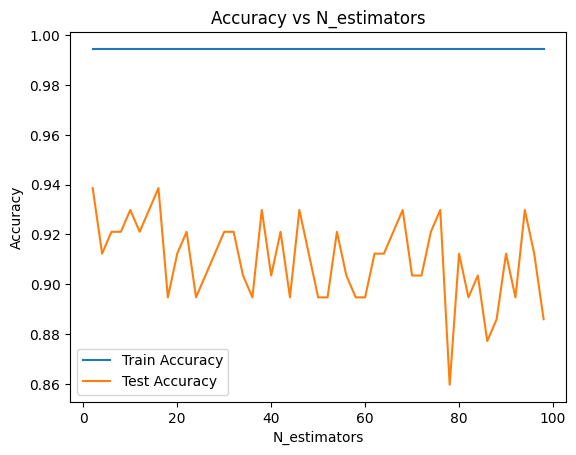

In [28]:
# n_est_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25]
n_est_lst = [i for i in range(2, 100, 2)]
plot_accuracy_vs_n_estimators(
    n_est_lst=n_est_lst,
    X_test=X_test,
    X_train=X_train,
    y_test=y_test,
    y_train=y_train,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"]
)

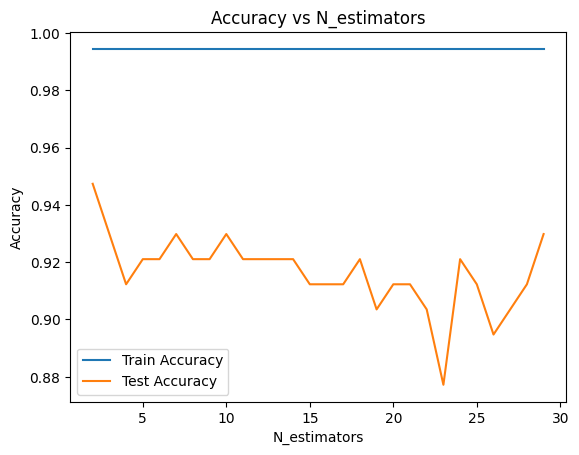

In [29]:
n_est_lst = [i for i in range(2, 30)]
plot_accuracy_vs_n_estimators(
    n_est_lst=n_est_lst,
    X_test=X_test,
    X_train=X_train,
    y_test=y_test,
    y_train=y_train,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"]
)

In [30]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [31]:
class CustomRandomForest:
    def __init__(
            self,
            n_estimators: int = 50,
            max_depth: int = 1,
            min_samples_split: int = 2,
            min_samples_leaf: int = 1,
    ):
        self.n_estimators: int = n_estimators
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split
        self.min_samples_leaf: int = min_samples_leaf
        self.trees: list[DecisionTreeClassifier] = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_part = X[indices]
            y_part = y[indices]
            dt = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            dt.fit(X_part, y_part)
            self.trees.append(dt)

    def predict(self, X: np.ndarray) -> np.ndarray:
        n_samples = X.shape[0]
        n_trees = len(self.trees)
        predictions = np.zeros((n_samples, n_trees))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        return np.array([np.bincount(predictions[i].astype(int)).argmax() for i in range(n_samples)])

In [32]:
def test_random_forest() -> None:
    X_test, X_train, y_test, y_train = _get_split_data()
    random_forest = CustomRandomForest(n_estimators=1000, max_depth=3)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    print_accuracy(y_pred, y_test)


In [33]:
test_random_forest()

Test Accuracy: 0.956140350877193


In [34]:
def func(trial, X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray) -> float:
    n_estimators = trial.suggest_int('n_estimators', 2, 10)
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 30)
    random_forest = CustomRandomForest(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [35]:
def get_best_hyperparameters(
        X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray
) -> tuple[dict, float]:
    study = optuna.create_study(direction='maximize')
    study.optimize(
        func=lambda trial: func(trial, X_train, X_val, y_train, y_val),
        n_trials=100,
        show_progress_bar=True
    )
    best_params = study.best_params
    best_value = study.best_value
    return best_params, best_value


In [36]:
X_test, X_train, X_val, y_test, y_train, y_val = get_split_data()
best_params, best_score = get_best_hyperparameters(X_train, X_val, y_train, y_val)
print("~" * 40)
pretty_print_best_params(best_params, best_score)

[I 2024-09-11 16:28:55,073] A new study created in memory with name: no-name-247c1b3a-ae69-44c7-b1df-d9d000bda7f8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-09-11 16:28:55,084] Trial 0 finished with value: 0.9120879120879121 and parameters: {'n_estimators': 3, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9120879120879121.
[I 2024-09-11 16:28:55,098] Trial 1 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 6, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9230769230769231.
[I 2024-09-11 16:28:55,103] Trial 2 finished with value: 0.8901098901098901 and parameters: {'n_estimators': 2, 'max_depth': 5, 'min_samples_split': 21, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.9230769230769231.
[I 2024-09-11 16:28:55,111] Trial 3 finished with value: 0.9010989010989011 and parameters: {'n_estimators': 3, 'max_depth': 22, 'min_samples_split': 26, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.9230769230769231.
[I 2024-09-11 16:28:55,124] Trial 4 finished with value: 0.8901098901098901 and parameters: {'n_

In [37]:
def plot_accuracy_vs_n_estimators(X_test, X_train, y_test, y_train,
                                  max_depth, min_samples_split, min_samples_leaf, n_est_lst):
    train_accuracies = []
    test_accuracies = []

    for n_est in n_est_lst:
        random_forest = CustomRandomForest(
            n_estimators=n_est,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
        )
        random_forest.fit(X_train, y_train)

        y_train_pred = random_forest.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_test_pred = random_forest.predict(X_test)
        test_accuracies.append(accuracy_score(y_test, y_test_pred))

    plt.plot(n_est_lst, train_accuracies, label='Train Accuracy')
    plt.plot(n_est_lst, test_accuracies, label='Test Accuracy')
    plt.xlabel('N_estimators')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs N_estimators')
    plt.legend()
    plt.show()

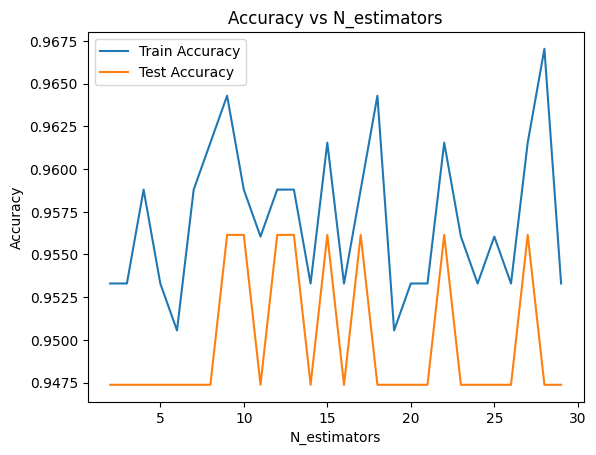

In [38]:
n_est_lst = [i for i in range(2, 30)]
plot_accuracy_vs_n_estimators(
    n_est_lst=n_est_lst,
    X_test=X_test,
    X_train=X_train,
    y_test=y_test,
    y_train=y_train,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"]
)

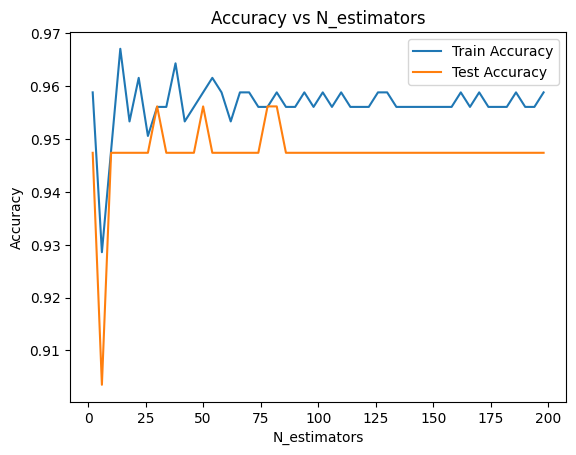

In [39]:
n_est_lst = [i for i in range(2, 200, 4)]
plot_accuracy_vs_n_estimators(
    n_est_lst=n_est_lst,
    X_test=X_test,
    X_train=X_train,
    y_test=y_test,
    y_train=y_train,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"]
)